In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 设置图形样式

plt.rcParams['figure.figsize'] = (14, 6)

# loading data

In [2]:
train = pd.read_csv('hull-tactical-market-prediction/train.csv')
test = pd.read_csv('hull-tactical-market-prediction/test.csv')

# EDA
- 可视化初步分析预测目标分布
- 缺失特征分析
- 自相关性分析
- 特征分析

In [10]:
print(train.head(5))
print(f"训练集大小: {train.shape}, 测试集大小: {test.shape}")
print(train.dtypes)
print(f'时间范围: 从 {train["date_id"].min()} 到 {train["date_id"].max()}，共计 { len(train["date_id"])} 天')


   date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...  V3  V4  V5  V6  V7  V8  \
0        0   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
1        1   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
2        2   0   0   0   1   0   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
3        3   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   
4        4   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   

   V9  forward_returns  risk_free_rate  market_forward_excess_returns  
0 NaN        -0.002421        0.000301                      -0.003038  
1 NaN        -0.008495        0.000303                      -0.009114  
2 NaN        -0.009624        0.000301                      -0.010243  
3 NaN         0.004662        0.000299                       0.004046  
4 NaN        -0.011686        0.000299                      -0.012301  

[5 rows x 98 columns]
训练集大小: (9021, 98), 测试集大小: (10, 99)
date_id                            

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entries, 0 to 9020
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_id                        9021 non-null   int64  
 1   D1                             9021 non-null   int64  
 2   D2                             9021 non-null   int64  
 3   D3                             9021 non-null   int64  
 4   D4                             9021 non-null   int64  
 5   D5                             9021 non-null   int64  
 6   D6                             9021 non-null   int64  
 7   D7                             9021 non-null   int64  
 8   D8                             9021 non-null   int64  
 9   D9                             9021 non-null   int64  
 10  E1                             7237 non-null   float64
 11  E10                            8015 non-null   float64
 12  E11                            8015 non-null   f

In [19]:
print("\n" + "="*80)
print(" 目标变量分析 ")
print("="*80)
target = train['market_forward_excess_returns'].values
risk_free_rate = train['risk_free_rate'].values
forward_returns = train['forward_returns'].values

print(f"\n 目标变量统计:")
print(f"  平均值:     {target.mean():.6f} ({target.mean()*252*100:.2f}% 年化)")
print(f"  中位数:   {np.median(target):.6f}")
print(f"  标准差:      {target.std():.6f} ({target.std()*np.sqrt(252)*100:.2f}% 年化)")
print(f"  最小值:      {target.min():.6f}")
print(f"  最大值:      {target.max():.6f}")
print(f"  偏度: {stats.skew(target):.3f}")
print(f"  峰度: {stats.kurtosis(target):.3f} (excess)")
print(f"  缺失值数量: {np.sum(pd.isnull(target))}")

sharpe = (target.mean() / target.std()) * np.sqrt(252)
print(f"\n 基线夏普比率: {sharpe:.3f}")

print(f"\n return分布:")
print(f"  正收益天数: {(target > 0).sum()} ({(target > 0).sum()/len(target)*100:.1f}%)")
print(f"  负收益天数: {(target < 0).sum()} ({(target < 0).sum()/len(target)*100:.1f}%)")
print(f"  接近零 (<0.1%): {(np.abs(target) < 0.001).sum()}")

print(f"\n 极端事件 (>2倍标准差):")
extreme_positive = (target > target.mean() + 2*target.std()).sum()
extreme_negative = (target < target.mean() - 2*target.std()).sum()
print(f"  极端正收益天数: {extreme_positive} 天")
print(f"  极端负收益天数: {extreme_negative} 天")
print(f"  极端事件总数: {extreme_positive + extreme_negative} ({(extreme_positive + extreme_negative)/len(target)*100:.1f}%)")


 目标变量分析 

 目标变量统计:
  平均值:     0.000053 (1.34% 年化)
  中位数:   0.000255
  标准差:      0.010558 (16.76% 年化)
  最小值:      -0.040582
  最大值:      0.040551
  偏度: -0.180
  峰度: 2.244 (excess)
  缺失值数量: 0

 基线夏普比率: 0.080

 return分布:
  正收益天数: 4662 (51.7%)
  负收益天数: 4359 (48.3%)
  接近零 (<0.1%): 1086

 极端事件 (>2倍标准差):
  极端正收益天数: 229 天
  极端负收益天数: 320 天
  极端事件总数: 549 (6.1%)


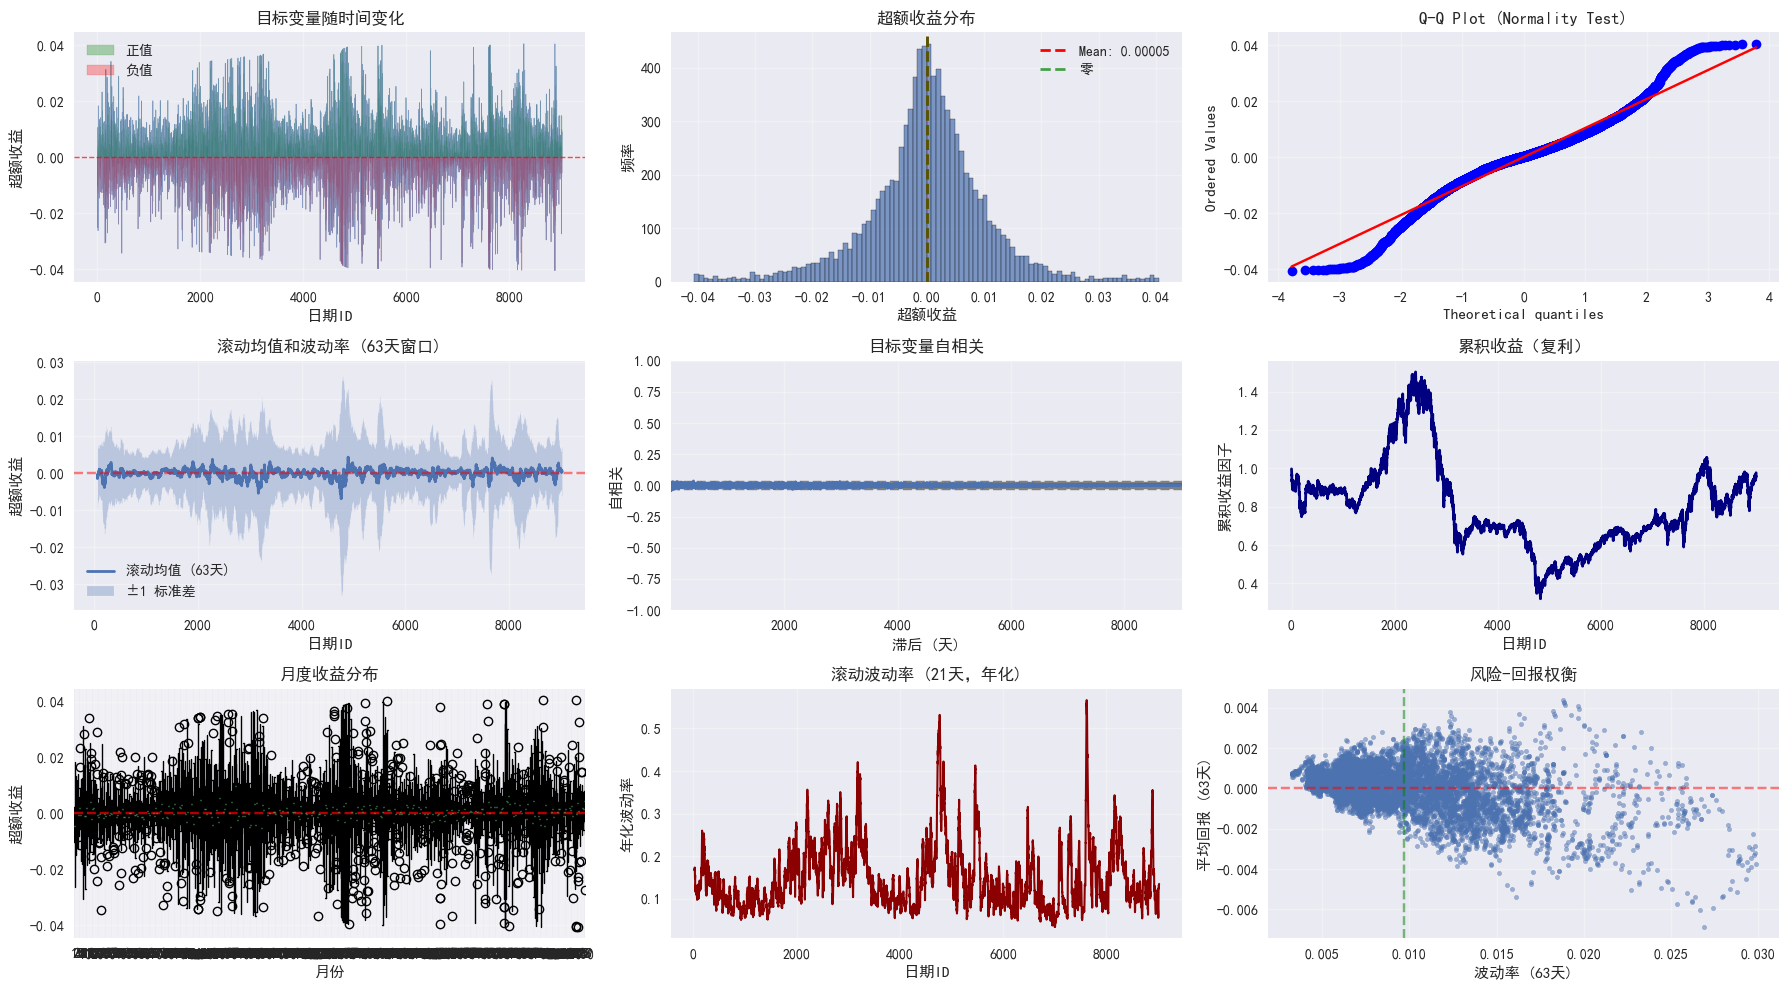

In [24]:
fig = plt.figure(figsize=(18, 10))

# 时间序列图
ax1 = plt.subplot(3, 3, 1)
plt.plot(train['date_id'], target, alpha=0.6, linewidth=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
plt.fill_between(train['date_id'], 0, target, where=(target>0), alpha=0.3, color='green', label='正值')
plt.fill_between(train['date_id'], 0, target, where=(target<0), alpha=0.3, color='red', label='负值')
plt.title('目标变量随时间变化', fontsize=12, fontweight='bold')
plt.xlabel('日期ID')
plt.ylabel('超额收益')
plt.legend()
plt.grid(True, alpha=0.3)

# 分布直方图
ax2 = plt.subplot(3, 3, 2)
plt.hist(target, bins=100, edgecolor='black', alpha=0.7)
plt.axvline(target.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {target.mean():.5f}')
plt.axvline(0, color='green', linestyle='--', linewidth=2, alpha=0.7, label='零')
plt.title('超额收益分布', fontsize=12, fontweight='bold')
plt.xlabel('超额收益')
plt.ylabel('频率')
plt.legend()
plt.grid(True, alpha=0.3)

# Q-Q图（正态性检验）
ax3 = plt.subplot(3, 3, 3)
stats.probplot(target, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Test)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 滚动均值和标准差
ax4 = plt.subplot(3, 3, 4)
rolling_mean = pd.Series(target).rolling(window=63).mean()  # ~3个月
rolling_std = pd.Series(target).rolling(window=63).std()
plt.plot(train['date_id'], rolling_mean, label='滚动均值 (63天)', linewidth=2)
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.fill_between(train['date_id'], rolling_mean - rolling_std, rolling_mean + rolling_std,
                 alpha=0.3, label='±1 标准差')
plt.title('滚动均值和波动率 (63天窗口)', fontsize=12, fontweight='bold')
plt.xlabel('日期ID')
plt.ylabel('超额收益')
plt.legend()
plt.grid(True, alpha=0.3)

# 自相关
ax5 = plt.subplot(3, 3, 5)
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(pd.Series(target))
plt.title('目标变量自相关', fontsize=12, fontweight='bold')
plt.xlabel('滞后 (天)')
plt.ylabel('自相关')
plt.grid(True, alpha=0.3)

# 累积收益
ax6 = plt.subplot(3, 3, 6)
cumulative_returns = (1 + pd.Series(target)).cumprod()
plt.plot(train['date_id'], cumulative_returns, linewidth=2, color='navy')
plt.title('累积收益（复利）', fontsize=12, fontweight='bold')
plt.xlabel('日期ID')
plt.ylabel('累积收益因子')
plt.grid(True, alpha=0.3)

# 月度收益箱线图
ax7 = plt.subplot(3, 3, 7)
train['month'] = train['date_id'] // 21  # 近似月份
monthly_data = train.groupby('month')['market_forward_excess_returns'].apply(list)
plt.boxplot([m for m in monthly_data if len(m) > 0], showfliers=True)
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.title('月度收益分布', fontsize=12, fontweight='bold')
plt.xlabel('月份')
plt.ylabel('超额收益')
plt.grid(True, alpha=0.3)

# 波动率随时间变化
ax8 = plt.subplot(3, 3, 8)
rolling_vol = pd.Series(target).rolling(window=21).std()  # ~1个月
plt.plot(train['date_id'], rolling_vol * np.sqrt(252), linewidth=1.5, color='darkred')
plt.title('滚动波动率 (21天，年化)', fontsize=12, fontweight='bold')
plt.xlabel('日期ID')
plt.ylabel('年化波动率')
plt.grid(True, alpha=0.3)

# 回报率与波动率的散点图
ax9 = plt.subplot(3, 3, 9)
window = 63
rolling_ret = pd.Series(target).rolling(window=window).mean()
rolling_vol = pd.Series(target).rolling(window=window).std()
plt.scatter(rolling_vol, rolling_ret, alpha=0.5, s=10)
plt.xlabel('波动率 (63天)')
plt.ylabel('平均回报 (63天)')
plt.title('风险-回报权衡', fontsize=12, fontweight='bold')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.axvline(rolling_vol.mean(), color='green', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

plt.tight_layout()


 特征组摘要:
组别       数量       缺失比例(%)      描述
--------------------------------------------------------------------------------
D        9        0.0          Categorical/Binary Regime Indicators
E        20       15.2         Economic Indicators
I        9        11.2         Interest Rate Features
M        18       25.4         Market Features
P        13       12.7         Price/Performance Features
S        12       20.2         Sentiment Features
V        13       19.8         Volatility Features

 缺失数据摘要:
  总特征数: 95
  存在缺失值的特征数: 85
  缺失比例超过50%的特征数: 8
  缺失比例超过80%的特征数: 0

 缺失比例最高的10个特征:
feature  missing_count  missing_pct  first_valid_idx group
     E7           6969    77.253076             6969     E
    V10           6049    67.054650             6049     V
     S3           5733    63.551713             5733     S
     M1           5547    61.489857             5547     M
    M13           5540    61.412260             5540     M
    M14           5540    61.412260             5540

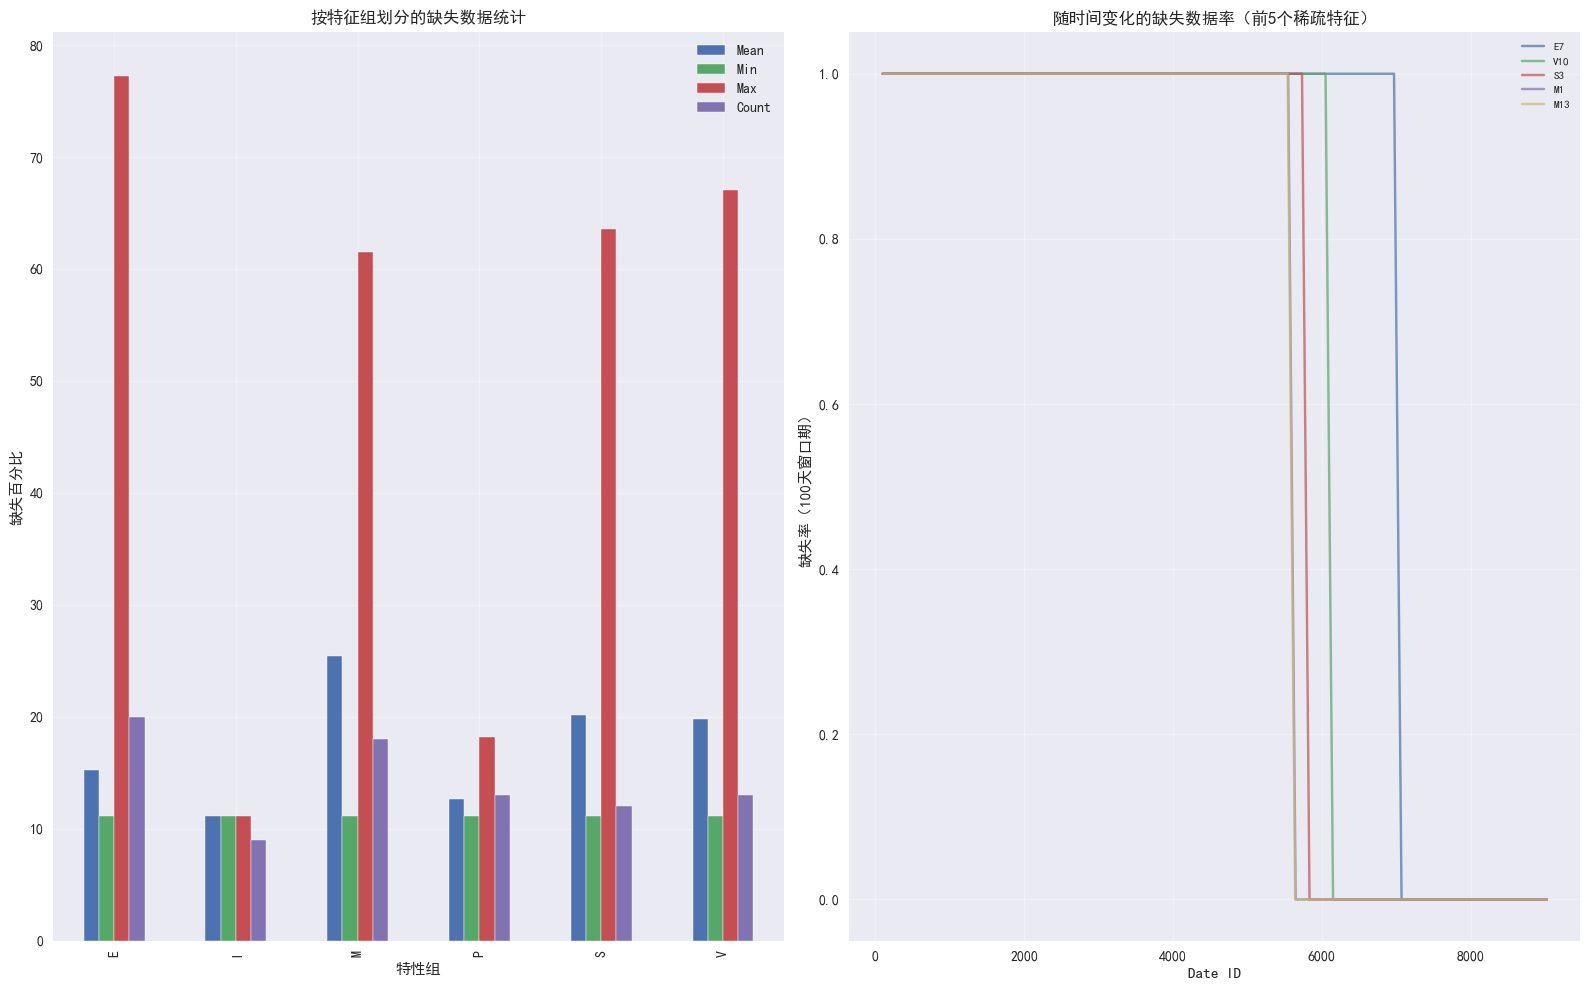

In [41]:
# 缺失值分析与可视化
feature_groups = {}
for prefix in ['D', 'E', 'I', 'M', 'P', 'S', 'V']:
    cols = [c for c in train.columns if c.startswith(prefix)]
    feature_groups[prefix] = cols

group_descriptions = {
    'D': 'Categorical/Binary Regime Indicators',
    'E': 'Economic Indicators',
    'I': 'Interest Rate Features',
    'M': 'Market Features',
    'P': 'Price/Performance Features',
    'S': 'Sentiment Features',
    'V': 'Volatility Features'
}

print(f"\n 特征组摘要:")
print(f"{'组别':<8} {'数量':<8} {'缺失比例(%)':<12} {'描述'}")
print("-" * 80)

for prefix, cols in feature_groups.items():
    if len(cols) > 0:
        missing_pct = train[cols].isnull().sum().sum() / (len(train) * len(cols)) * 100
        print(f"{prefix:<8} {len(cols):<8} {missing_pct:<12.1f} {group_descriptions[prefix]}")

# Calculate missing percentages
missing_analysis = []
for col in train.columns:
    if col not in ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']:
        missing_count = train[col].isnull().sum()
        if missing_count > 0:
            missing_pct = missing_count / len(train) * 100
            # When does missing data appear?
            first_non_null = train[col].first_valid_index()
            missing_analysis.append({
                'feature': col,
                'missing_count': missing_count,
                'missing_pct': missing_pct,
                'first_valid_idx': first_non_null,
                'group': col[0]
            })

missing_df = pd.DataFrame(missing_analysis).sort_values('missing_pct', ascending=False)

print(f"\n 缺失数据摘要:")
print(f"  总特征数: {len([c for c in train.columns if c not in ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']])}")
print(f"  存在缺失值的特征数: {len(missing_df)}")
print(f"  缺失比例超过50%的特征数: {(missing_df['missing_pct'] > 50).sum()}")
print(f"  缺失比例超过80%的特征数: {(missing_df['missing_pct'] > 80).sum()}")

print(f"\n 缺失比例最高的10个特征:")
print(missing_df.head(10).to_string(index=False))

# 按组计算缺失统计并可视化（按前缀分组）
group_stats = []
for prefix, cols in feature_groups.items():
    if len(cols) == 0:
        continue
    cols = [c for c in cols if c in train.columns]
    total_cells = len(train) * len(cols)
    total_missing = train[cols].isnull().sum().sum()
    # 每个特征首次非空索引（None -> np.nan）
    first_valids = [train[c].first_valid_index() for c in cols]
    first_valids = [fv for fv in first_valids if fv is not None]
    avg_first = np.nan if len(first_valids) == 0 else np.mean(first_valids)
    max_first = np.nan if len(first_valids) == 0 else np.max(first_valids)
    group_stats.append({
        'group': prefix,
        'n_features': len(cols),
        'missing_count': int(total_missing),
        'missing_pct': total_missing / total_cells * 100,
        'avg_first_valid_idx': avg_first,
        'max_first_valid_idx': max_first
    })

group_stats = pd.DataFrame(group_stats).sort_values('missing_pct', ascending=False).reset_index(drop=True)
print("\n 按组缺失统计:")
print(group_stats.to_string(index=False))

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

ax = axes[0]
group_missing = missing_df.groupby('group')['missing_pct'].agg(['mean', 'min', 'max', 'count'])
group_missing.plot(kind='bar', ax=ax)
ax.set_title('按特征组划分的缺失数据统计', fontsize=12, fontweight='bold')
ax.set_xlabel('特性组')
ax.set_ylabel('缺失百分比')
ax.legend(['Mean', 'Min', 'Max', 'Count'])
ax.grid(True, alpha=0.3)

# Sample a few high-missing features
ax = axes[1]
high_missing_features = missing_df.head(5)['feature'].tolist()
for feat in high_missing_features:
    missing_by_time = train[feat].isnull().rolling(window=100).mean()
    ax.plot(train['date_id'], missing_by_time, label=feat, alpha=0.7)
ax.set_title('随时间变化的缺失数据率（前5个稀疏特征）', fontsize=12, fontweight='bold')
ax.set_xlabel('Date ID')
ax.set_ylabel('缺失率（100天窗口期）')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()

In [42]:
correlations = []
for col in train.columns:
    if col not in ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']:
        valid_mask = train[col].notna()
        if valid_mask.sum() > 100:  
            corr_pearson, p_value = pearsonr(train.loc[valid_mask, col],
                                             train.loc[valid_mask, 'market_forward_excess_returns'])
            correlations.append({
                'feature': col,
                'correlation': corr_pearson,
                'abs_correlation': abs(corr_pearson),
                'p_value': p_value,
                'significant': p_value < 0.05,
                'group': col[0],
                'valid_samples': valid_mask.sum()
            })

corr_df = pd.DataFrame(correlations).sort_values('abs_correlation', ascending=False)

print(f"\n 相关性摘要:")
print(f"  分析的特征数: {len(corr_df)}")
print(f"  显著相关的特征数 (p<0.05): {corr_df['significant'].sum()}")
print(f"  相关系数 >0.05 的特征数: {(corr_df['abs_correlation'] > 0.05).sum()}")
print(f"  相关系数 >0.10 的特征数: {(corr_df['abs_correlation'] > 0.10).sum()}")

print(f"\n 相关性最高的15个特征:")
print(corr_df.head(15)[['feature', 'correlation', 'p_value', 'group']].to_string(index=False))

print(f"\n 相关性最低的15个特征:")
print(corr_df.tail(15)[['feature', 'correlation', 'p_value', 'group']].to_string(index=False))


 相关性摘要:
  分析的特征数: 95
  显著相关的特征数 (p<0.05): 20
  相关系数 >0.05 的特征数: 2
  相关系数 >0.10 的特征数: 0

 相关性最高的15个特征:
feature  correlation      p_value group
     M4    -0.066600 2.399974e-09     M
    V13     0.062395 6.248075e-08     V
     M1     0.046111 6.562556e-03     M
     S5     0.040010 5.241530e-04     S
     S2    -0.037886 6.927146e-04     S
     D2     0.033946 1.261156e-03     D
     D1     0.033946 1.261156e-03     D
     M2     0.033238 1.133070e-02     M
    V10     0.032635 7.526290e-02     V
     E7    -0.032294 1.436362e-01     E
    E11    -0.032131 4.016078e-03     E
     V7     0.031484 6.359893e-03     V
    E12    -0.030927 5.623295e-03     E
     P8    -0.029591 8.065733e-03     P
    S12     0.026134 5.296713e-02     S

 相关性最低的15个特征:
feature  correlation  p_value group
     E8    -0.001988 0.858729     E
     I4     0.001965 0.860377     I
     V5    -0.001935 0.866855     V
     V2     0.001914 0.863933     V
     E2    -0.001874 0.866784     E
     M9    -0.001810 0.871

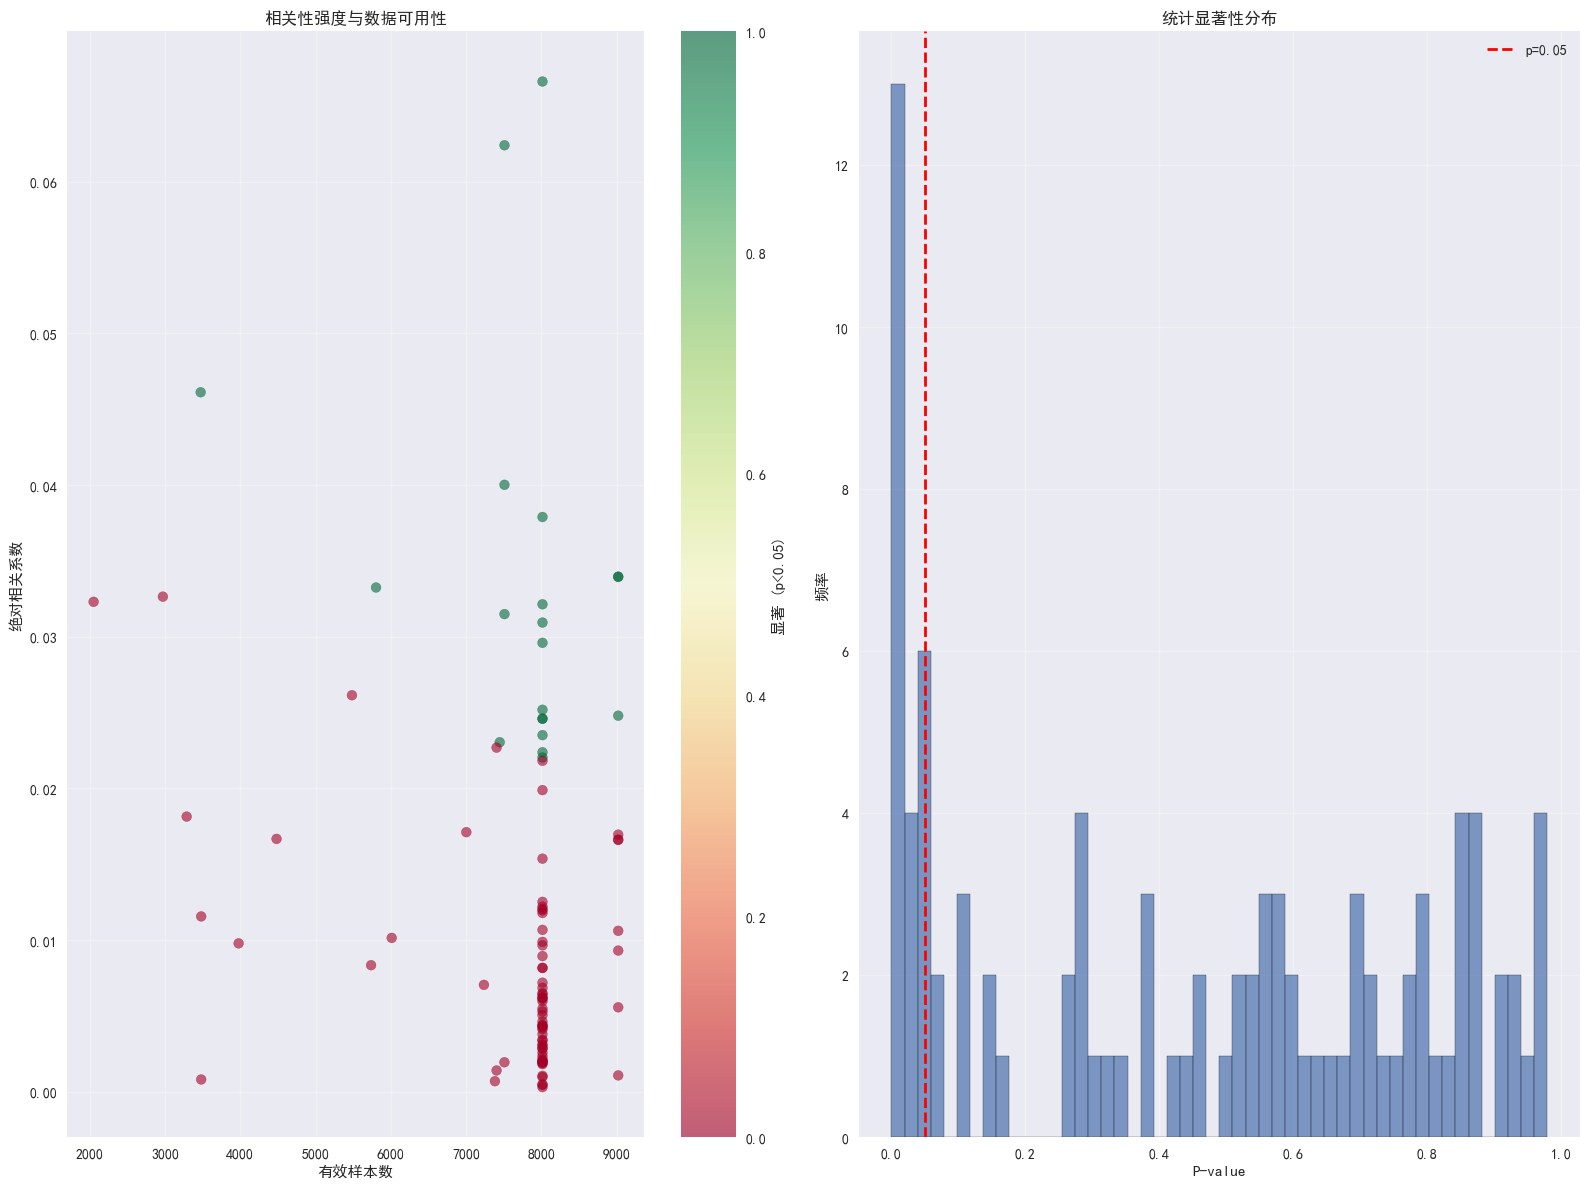

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(16, 12))
# 相关性与有效样本
ax = axes[0]
scatter = ax.scatter(corr_df['valid_samples'], corr_df['abs_correlation'],
                     c=corr_df['significant'], cmap='RdYlGn', alpha=0.6, s=50)
ax.set_xlabel('有效样本数')
ax.set_ylabel('绝对相关系数')
ax.set_title('相关性强度与数据可用性', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='显著 (p<0.05)')
ax.grid(True, alpha=0.3)

# P-value 分布
ax = axes[1]
ax.hist(corr_df['p_value'], bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0.05, color='red', linestyle='--', linewidth=2, label='p=0.05')
ax.set_xlabel('P-value')
ax.set_ylabel('频率')
ax.set_title('统计显著性分布', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()


 Found 9 regime 特征

 Regime 特征分析:

  D1:
 value  count       pct  mean_return  std_return    sharpe
     0   8736 96.840705    -0.000012    0.010534 -0.017360
     1    285  3.159295     0.002037    0.011124  2.907558

  D2:
 value  count       pct  mean_return  std_return    sharpe
     0   8736 96.840705    -0.000012    0.010534 -0.017360
     1    285  3.159295     0.002037    0.011124  2.907558

  D3:
 value  count       pct  mean_return  std_return   sharpe
     0   8590 95.222259     0.000040    0.010560 0.060231
     1    431  4.777741     0.000315    0.010526 0.475401

  D4:
 value  count       pct  mean_return  std_return    sharpe
     1   5178 57.399401     0.000207    0.010747  0.306239
     0   3843 42.600599    -0.000154    0.010296 -0.238084

  D5:
 value  count       pct  mean_return  std_return    sharpe
     1   1718 19.044452     0.000415    0.010783  0.610680
     0   7303 80.955548    -0.000032    0.010504 -0.048132

  D6:
 value  count       pct  mean_return  std

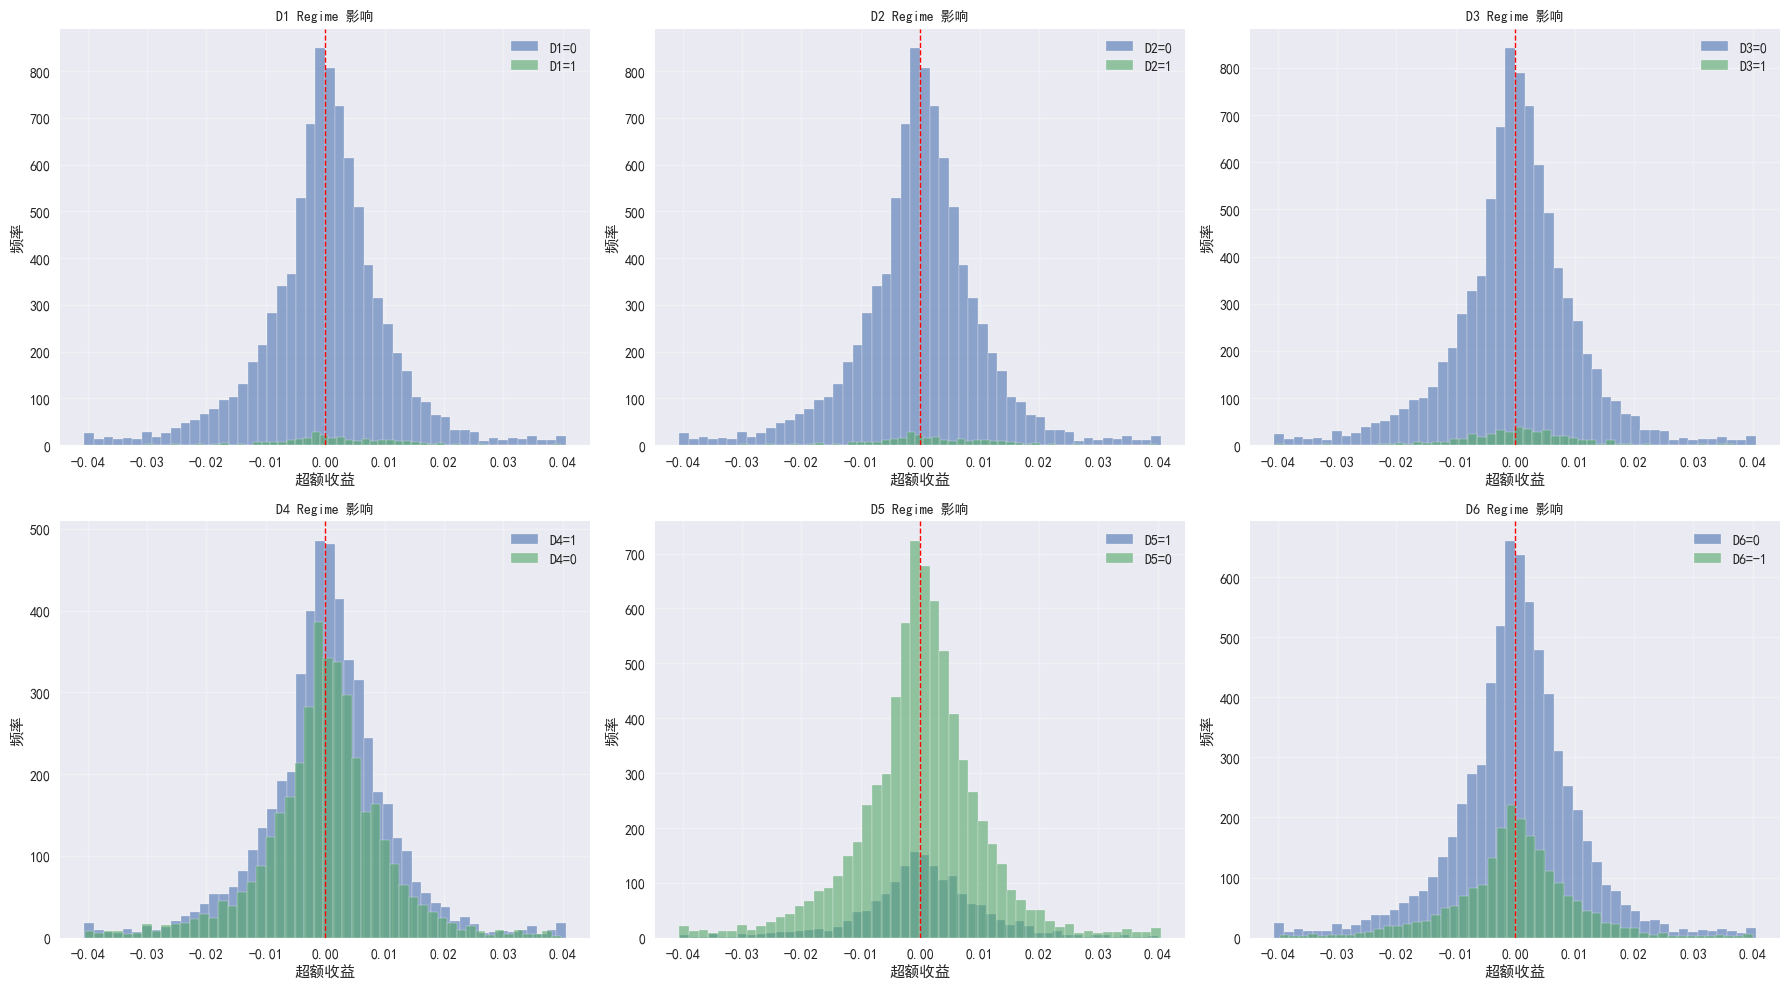

In [44]:
d_cols = [c for c in train.columns if c.startswith('D')]

if len(d_cols) > 0:
    print(f"\n Found {len(d_cols)} regime 特征")

    print(f"\n Regime 特征分析:")
    for col in d_cols:
        unique_vals = train[col].unique()
        value_counts = train[col].value_counts()

        # 计算按 Regime 分组的目标统计
        regime_stats = []
        for val in unique_vals:
            mask = train[col] == val
            regime_returns = train.loc[mask, 'market_forward_excess_returns']
            regime_stats.append({
                'value': val,
                'count': mask.sum(),
                'pct': mask.sum() / len(train) * 100,
                'mean_return': regime_returns.mean(),
                'std_return': regime_returns.std(),
                'sharpe': (regime_returns.mean() / regime_returns.std()) * np.sqrt(252) if regime_returns.std() > 0 else 0
            })

        regime_df = pd.DataFrame(regime_stats)
        print(f"\n  {col}:")
        print(regime_df.to_string(index=False))

    # 可视化 regime 影响
    print("\n 创建 regime 分析可视化...")

    n_regimes = min(len(d_cols), 6)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, col in enumerate(d_cols[:n_regimes]):
        ax = axes[idx]

        for val in train[col].unique():
            mask = train[col] == val
            regime_data = train.loc[mask, 'market_forward_excess_returns']
            ax.hist(regime_data, bins=50, alpha=0.6, label=f'{col}={val}')

        ax.axvline(0, color='red', linestyle='--', linewidth=1)
        ax.set_xlabel('超额收益')
        ax.set_ylabel('频率')
        ax.set_title(f'{col} Regime 影响', fontsize=10, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
else:
    print("⚠ No D (regime) features found")

In [ ]:
# 增强迪基-富勒检验
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(target[~np.isnan(target)])
print(f"  ADF 统计量: {adf_result[0]:.4f}")
print(f"  P值: {adf_result[1]:.4f}")
print(f"  结果: {'平稳 ✓' if adf_result[1] < 0.05 else '非平稳 ⚠'}")

# 自相关分析
print(f"\n 关键滞后期的自相关性:")
for lag in [1, 5, 21, 63]:
    if len(target) > lag:
        autocorr = pd.Series(target).autocorr(lag=lag)
        print(f"  Lag {lag:3d}: {autocorr:7.4f}")

  ADF 统计量: -17.5318
  P值: 0.0000
  结果: 平稳 ✓

 关键滞后期的自相关性:
  Lag   1: -0.0450
  Lag   5: -0.0233
  Lag  21: -0.0036
  Lag  63:  0.0087


# Data preprocessing and feature engineering
- 滞后特征构建
- 添加外部数据，增加宏观经济指标，技术指标
- 参数设定

# Modeling
- lightbgm
- LSTM
- 融合方法
- 输出每日持仓

# Visualising